## Import the Library

In [4]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2
import random
from functools import reduce

## Add your crendentials

In [23]:
# Insert your Spotify username and the credentials that you obtained from spotify developer
cid = '7a2ee58995f7488e8d14120fea5402fe'
secret = 'ab97da5b2df24042afd5398b8b1c29b5'
redirect_uri='http://localhost:1234'
username = '113586775'

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)

try:
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
except:
    print("error")

In [24]:
# Once the Authorisation is complete, we just need to `sp` to call the APIs
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

## Fetch the user's favourite songs
Now the API authnetication is complete, let's test it by getting users favourite songs

In [25]:
results = sp.current_user_top_tracks(limit=20, offset=0, time_range='medium_term')
results

{'items': [{'album': {'album_type': 'SINGLE',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5Pwc4xIPtQLFEnJriah9YJ'},
      'href': 'https://api.spotify.com/v1/artists/5Pwc4xIPtQLFEnJriah9YJ',
      'id': '5Pwc4xIPtQLFEnJriah9YJ',
      'name': 'OneRepublic',
      'type': 'artist',
      'uri': 'spotify:artist:5Pwc4xIPtQLFEnJriah9YJ'}],
    'available_markets': ['AD',
     'AE',
     'AR',
     'AT',
     'AU',
     'BE',
     'BG',
     'BH',
     'BO',
     'BR',
     'CA',
     'CH',
     'CL',
     'CO',
     'CR',
     'CY',
     'CZ',
     'DE',
     'DK',
     'DO',
     'DZ',
     'EC',
     'EE',
     'EG',
     'ES',
     'FI',
     'FR',
     'GB',
     'GR',
     'GT',
     'HK',
     'HN',
     'HU',
     'ID',
     'IE',
     'IL',
     'IN',
     'IS',
     'IT',
     'JO',
     'JP',
     'KW',
     'LB',
     'LI',
     'LT',
     'LU',
     'LV',
     'MA',
     'MC',
     'MT',
     'MX',
     'MY',
     'NI',
     'NL',
     'NO',
 

In [44]:
# Convert it to Dataframe
track_name = []
track_id = []
artist = []
album = []
duration = []
popularity = []
for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

# Create the final df   
df_favourite = pd.DataFrame({ "track_name": track_name, 
                             "album": album, 
                             "track_id": track_id,
                             "artist": artist, 
                             "duration": duration, 
                             "popularity": popularity})

df_favourite

,track_name,album,track_id,artist,duration,popularity
0,I Ain't Worried,I Ain’t Worried (Music From The Motion Picture...,4h9wh7iOZ0GGn8QVp4RAOB,OneRepublic,148485,95
1,I Like You (A Happier Song) (with Doja Cat),Twelve Carat Toothache,0O6u0VJ46W86TxN9wgyqDj,Post Malone,192840,89
2,Left and Right (Feat. Jung Kook of BTS),Left and Right (Feat. Jung Kook of BTS),0mBP9X2gPCuapvpZ7TGDk3,Charlie Puth,154486,87
3,Dandelions,Safe Haven,2eAvDnpXP5W0cVtiI0PUxV,Ruth B.,233720,90
4,As It Was,As It Was,4LRPiXqCikLlN15c3yImP7,Harry Styles,167303,93
5,Sunroof,Sunroof,4h4QlmocP3IuwYEj2j14p8,Nicky Youre,163025,89
6,SNAP,SNAP,76OGwb5RA9h4FxQPT33ekc,Rosa Linn,179551,93


In [45]:
def fetch_audio_features(sp, df):
    playlist = df[['track_id','track_name']] 
    index = 0
    audio_features = []
    
    # Make the API request
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 50, 0])
        index += 50
    
    # Create an empty list to feed in different charactieritcs of the tracks
    features_list = []
    #Create keys-values of empty lists inside nested dictionary for album
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['acousticness'],
                              features['energy'], 
                              features['tempo'],
                              features['instrumentalness'], 
                              features['loudness'],
                              features['liveness'],
                              features['duration_ms'],
                              features['key'],
                              features['valence'],
                              features['speechiness'],
                              features['mode']
                             ])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'acousticness', 'energy','tempo', 
                                                             'instrumentalness', 'loudness', 'liveness','duration_ms', 'key',
                                                             'valence', 'speechiness', 'mode'])
    
    # Create the final df, using the 'track_id' as index for future reference
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_name', inplace=True, drop=True)
    return df_playlist_audio_features

In [46]:
df_playlist_audio_features = fetch_audio_features (sp, df_favourite)
df_playlist_audio_features

,track_id,danceability,acousticness,energy,tempo,instrumentalness,loudness,liveness,duration_ms,key,valence,speechiness,mode
track_name,,,,,,,,,,,,,
I Ain't Worried,4h9wh7iOZ0GGn8QVp4RAOB,0.704,0.0826,0.797,139.994,0.000745,-5.927,0.0546,148486,0,0.825,0.0475,1
I Like You (A Happier Song) (with Doja Cat),0O6u0VJ46W86TxN9wgyqDj,0.733,0.1210,0.670,100.964,0.000000,-6.009,0.1210,192841,5,0.472,0.0751,1
Left and Right (Feat. Jung Kook of BTS),0mBP9X2gPCuapvpZ7TGDk3,0.881,0.6190,0.592,101.058,0.000013,-4.898,0.0901,154487,2,0.719,0.0324,1
Dandelions,2eAvDnpXP5W0cVtiI0PUxV,0.609,0.0157,0.692,116.959,0.000000,-2.958,0.0864,233720,1,0.454,0.0259,1
As It Was,4LRPiXqCikLlN15c3yImP7,0.520,0.3420,0.731,173.930,0.001010,-5.338,0.3110,167303,6,0.662,0.0557,0
Sunroof,4h4QlmocP3IuwYEj2j14p8,0.768,0.3520,0.714,131.443,0.000000,-5.110,0.1500,163026,10,0.842,0.0401,1
SNAP,76OGwb5RA9h4FxQPT33ekc,0.565,0.1070,0.636,170.010,0.000010,-8.198,0.4470,179551,0,0.525,0.0638,1


In [47]:
df_playlist_audio_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, I Ain't Worried to SNAP
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          7 non-null      object 
 1   danceability      7 non-null      float64
 2   acousticness      7 non-null      float64
 3   energy            7 non-null      float64
 4   tempo             7 non-null      float64
 5   instrumentalness  7 non-null      float64
 6   loudness          7 non-null      float64
 7   liveness          7 non-null      float64
 8   duration_ms       7 non-null      int64  
 9   key               7 non-null      int64  
 10  valence           7 non-null      float64
 11  speechiness       7 non-null      float64
 12  mode              7 non-null      int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 784.0+ bytes


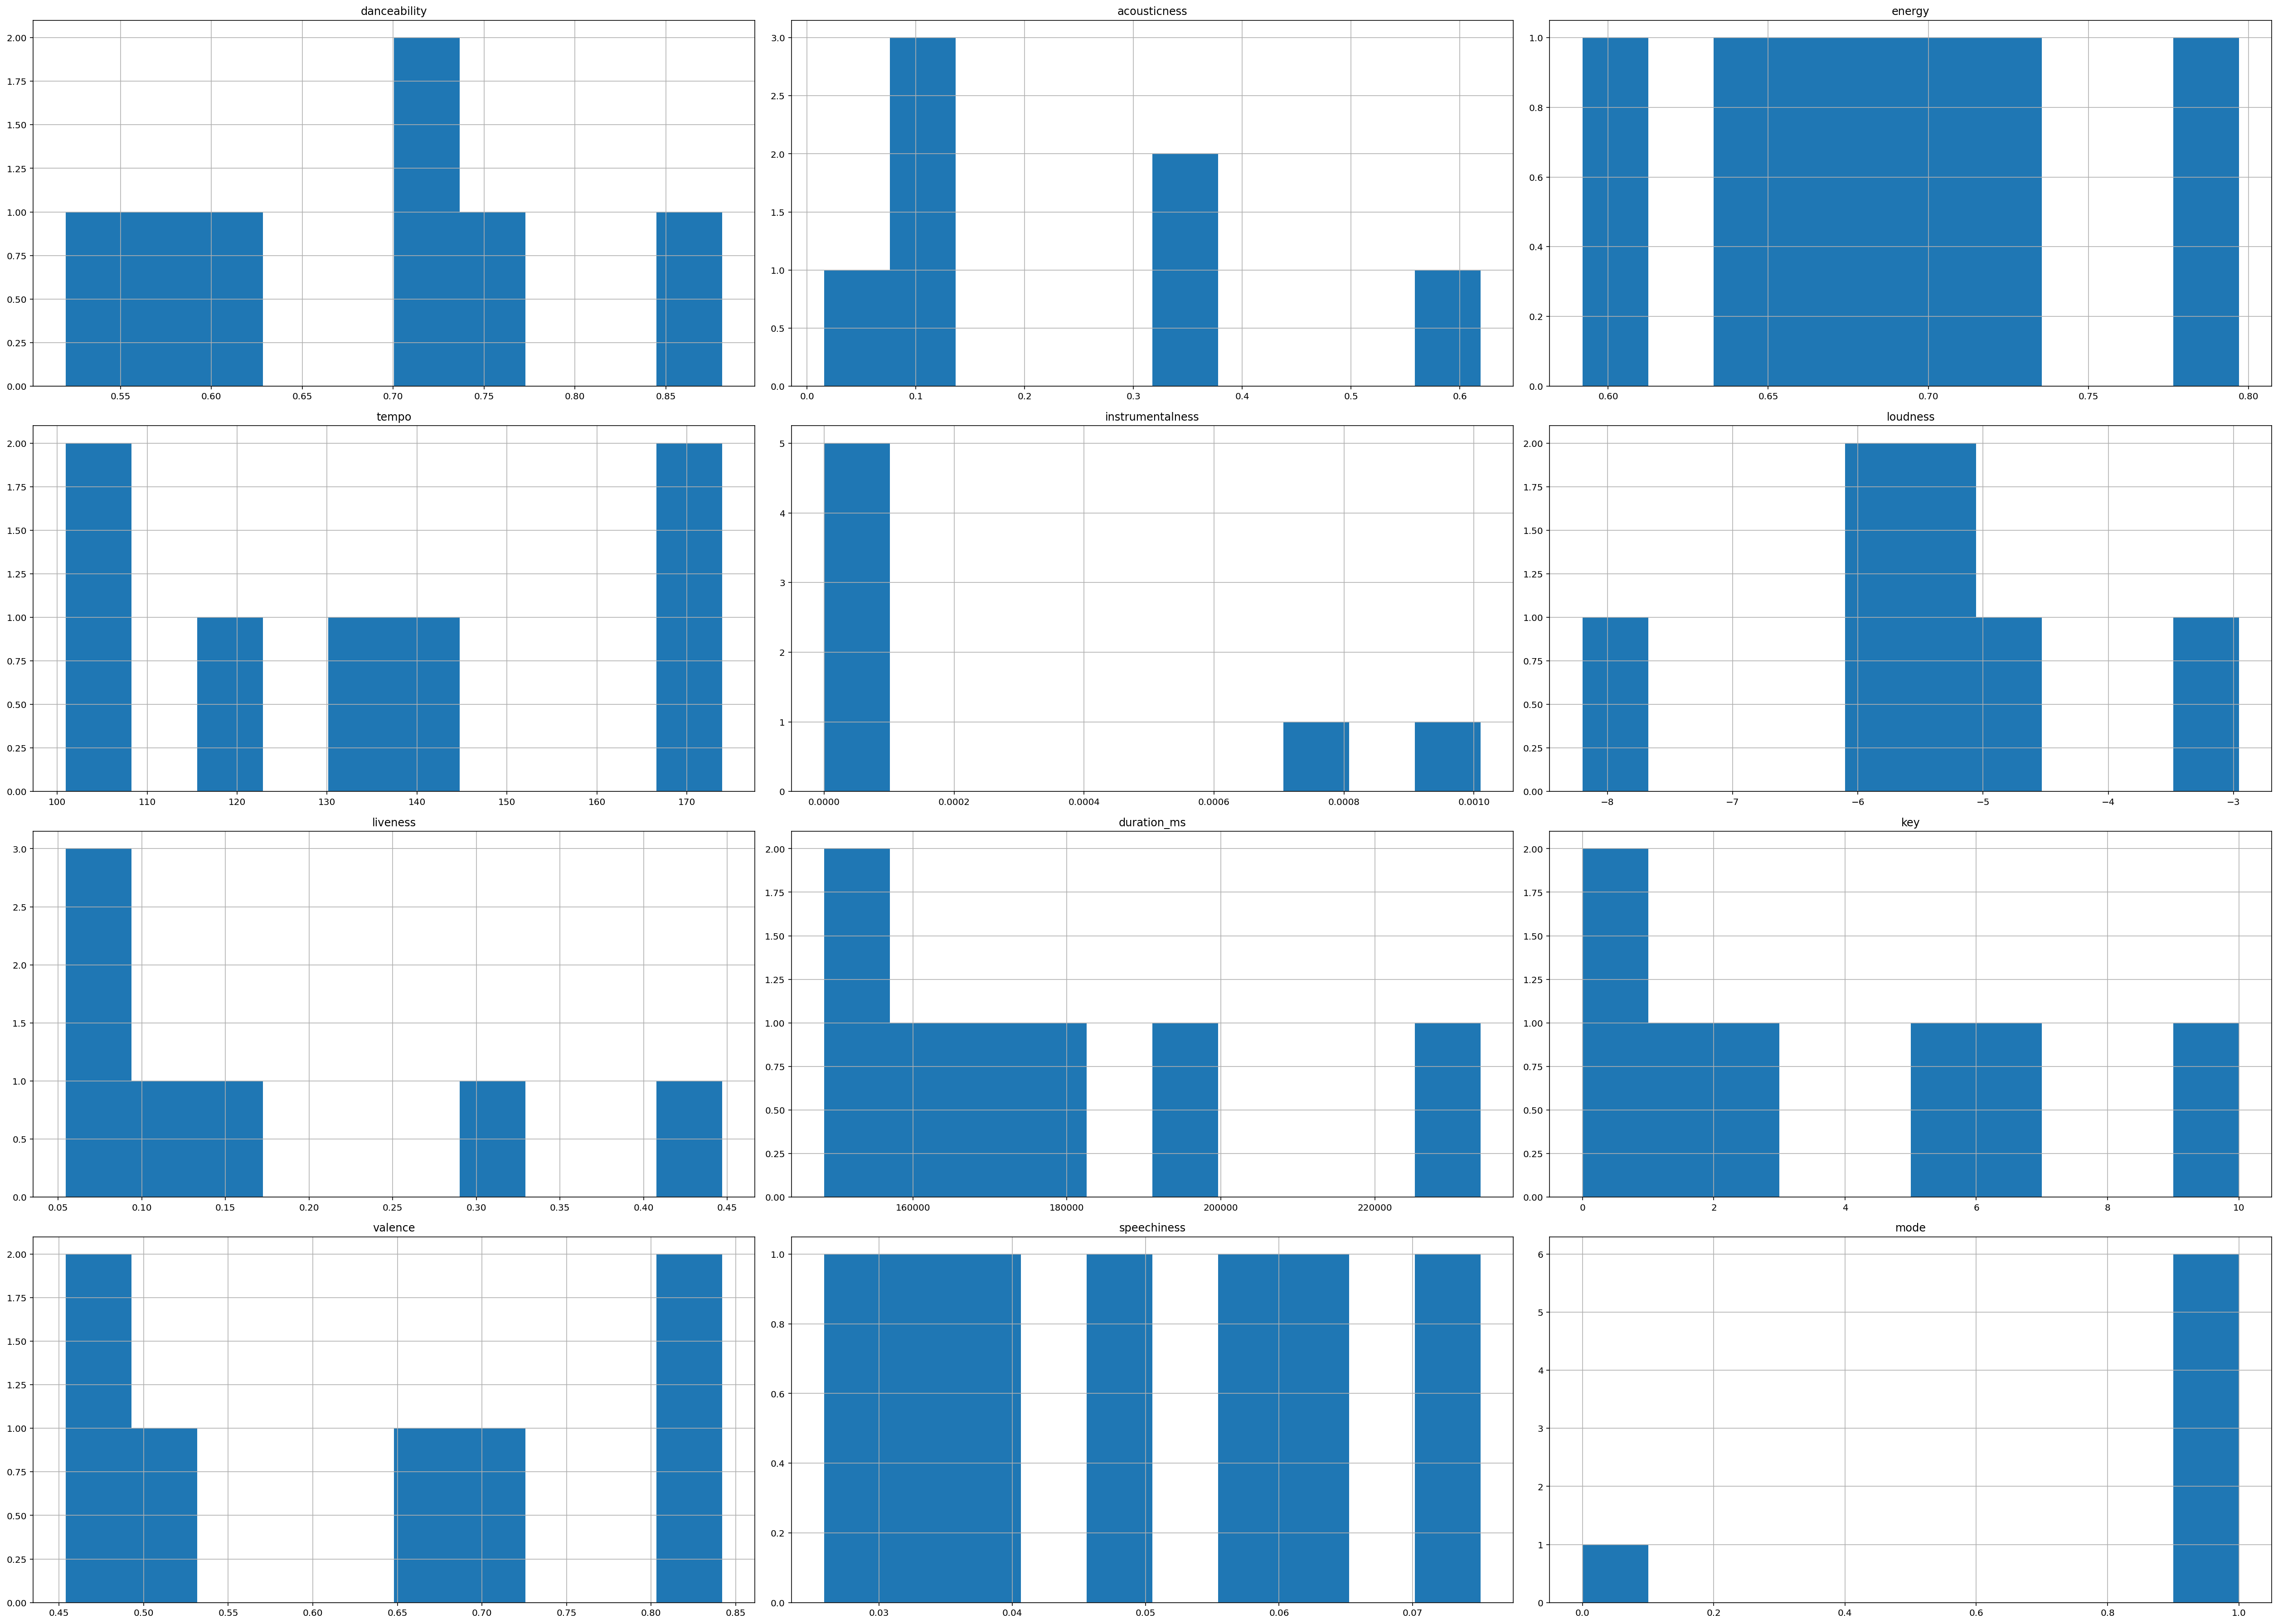

In [48]:
df_playlist_audio_features.hist(figsize=(35,25)) 
plt.tight_layout()
plt.show()

I would remove Mode it is binary number

## Fetch the Featured Playlist

In [49]:
response = sp.featured_playlists()
# check the format of the data 
response

{'message': 'Take it easy this morning',
 'playlists': {'href': 'https://api.spotify.com/v1/browse/featured-playlists?country=US&timestamp=2022-12-15T06%3A36%3A50&offset=0&limit=20',
  'items': [{'collaborative': False,
    'description': 'Wake up in your own pace with piano music.',
    'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DX7cZxYLqLUJl'},
    'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DX7cZxYLqLUJl',
    'id': '37i9dQZF1DX7cZxYLqLUJl',
    'images': [{'height': None,
      'url': 'https://i.scdn.co/image/ab67706f0000000386de24710c7230fcb6e08c13',
      'width': None}],
    'name': 'Wake Up Gently',
    'owner': {'display_name': 'Spotify',
     'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'},
     'href': 'https://api.spotify.com/v1/users/spotify',
     'id': 'spotify',
     'type': 'user',
     'uri': 'spotify:user:spotify'},
    'primary_color': None,
    'public': None,
    'snapshot_id': 'MTY0NzU5Mzk0MCwwMDAwMDA

In [50]:
# Let's untangle the data
print(response['message'])
playlists = response['playlists']
# For looping through the API request
for i, item in enumerate(playlists['items']):
    print('no: {},Name: {},id: {}, description: {}, total tracks: {}'.
          format(playlists['offset'] + i, item['name'], item['id'],item['description'], item['tracks']['total']))
if playlists['next']:
    response = sp.next(playlists)
else:
    response = None

Take it easy this morning
no: 0,Name: Wake Up Gently,id: 37i9dQZF1DX7cZxYLqLUJl, description: Wake up in your own pace with piano music., total tracks: 103
no: 1,Name: Rise,id: 37i9dQZF1DWUOhRIDwDB7M, description: Positive and uplifting ambient instrumental tracks., total tracks: 235
no: 2,Name: Throwback Thursday,id: 37i9dQZF1DWWwaxRea1LWS, description: Rock out with #SpotifyTBT to some 90s alternative. Cover: No Doubt. , total tracks: 50
no: 3,Name: Mellow Morning,id: 37i9dQZF1DWWzVPEmatsUB, description: Have a quiet morning with this mix of something familiar and something new., total tracks: 70
no: 4,Name: Country Rock Classics,id: 37i9dQZF1DX4bf0P6HTTom, description: Eagles, The Byrds and all your favorite country rock, total tracks: 50
no: 5,Name: Peace Of Mind,id: 37i9dQZF1DXaq9P62qly90, description: Conscious songs for everyday reflection., total tracks: 50
no: 6,Name: Sunny Day,id: 37i9dQZF1DX1BzILRveYHb, description: Easy listening pop for warmer days., total tracks: 75
no: 7

Once the data strucutre is sorted, next step is to convert this API call into a data frame

In [51]:
def featured_playlists(sp):
    id = []
    name = []
    num_tracks = []
 # For looping through the API request  
    response = sp.featured_playlists()
    playlists = response['playlists']
    for i, items in enumerate(playlists['items']):
        id.append(items['id'])
        name.append(items['name'])
        num_tracks.append(items['tracks']['total'])

# Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [52]:
df_playlists = featured_playlists(sp)
df_playlists

,id,name,#tracks
0,37i9dQZF1DX7cZxYLqLUJl,Wake Up Gently,103
1,37i9dQZF1DWUOhRIDwDB7M,Rise,235
2,37i9dQZF1DWWwaxRea1LWS,Throwback Thursday,50
3,37i9dQZF1DWWzVPEmatsUB,Mellow Morning,70
4,37i9dQZF1DX4bf0P6HTTom,Country Rock Classics,50
5,37i9dQZF1DXaq9P62qly90,Peace Of Mind,50
6,37i9dQZF1DX1BzILRveYHb,Sunny Day,75
7,37i9dQZF1DX7KNKjOK0o75,Have a Great Day!,80
8,37i9dQZF1DXaXDsfv6nvZ5,Soul Coffee,75
9,37i9dQZF1DXdVyc8LtLi96,Sunrise Yoga,306


## Obtain the tracks from the playlists

In [35]:
def fetch_playlist_tracks(sp, playlistsid): 
    offset = 0
    tracks = []
    # Make the API request
    while True:
            content = sp.playlist_tracks( playlistsid, fields=None, limit=100, offset=offset, market=None)
            tracks += content['items']
        
            if content['next'] is not None:
                offset += 100
            else:
                break
    
    track_id = []
    track_name = []
    
    for track in tracks:
        track_id.append(track['track']['id'])
        track_name.append(track['track']['name'])
    
# Create the final df
    df_playlists_tracks = pd.DataFrame({"track_id":track_id, "track_name": track_name})
    return df_playlists_tracks

In [53]:
# Test the function
df_playlists_tracks = fetch_playlist_tracks(sp,'37i9dQZF1DXdd3gw5QVjt9')

## Function to fetch the audio features from the songs of given playlist

In [54]:
def fetch_audio_features(sp, playlist_id):
    playlist = fetch_playlist_tracks(sp, playlist_id)
    index = 0
    audio_features = []
    
    # Make the API request
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 50, 0])
        index += 50
    
    # Create an empty list to feed in different charactieritcs of the tracks
    features_list = []
    #Create keys-values of empty lists inside nested dictionary for album
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['acousticness'],
                              features['energy'], 
                              features['tempo'],
                              features['instrumentalness'], 
                              features['loudness'],
                              features['liveness'],
                              features['duration_ms'],
                              features['key'],
                              features['valence'],
                              features['speechiness']
                             ])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'acousticness', 'energy','tempo', 
                                                             'instrumentalness', 'loudness', 'liveness', 'duration_ms', 'key',
                                                             'valence', 'speechiness'])
    
    # Create the final df, using the 'track_id' as index for future reference
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_name', inplace=True, drop=True)
    return df_playlist_audio_features

In [55]:
# Build the dtaframe froms the playlists
for i, playlist in enumerate(df_playlists['id']):
    try:
        string_command = "df_{} = fetch_audio_features(sp, playlist)".format(playlist)
        print("Create {}".format(string_command))
        exec(string_command)
    except:
        print("playlist with id {} is not valid, skiping ".format(playlist))
        pass

Create df_37i9dQZF1DX7cZxYLqLUJl = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DWUOhRIDwDB7M = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DWWwaxRea1LWS = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DWWzVPEmatsUB = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DX4bf0P6HTTom = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DXaq9P62qly90 = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DX1BzILRveYHb = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DX7KNKjOK0o75 = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DXaXDsfv6nvZ5 = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DXdVyc8LtLi96 = fetch_audio_features(sp, playlist)


In [58]:
def fetch_audio_features_mean(sp, playlist_id):
    playlist = fetch_audio_features(sp, playlist_id)
    return pd.DataFrame(playlist.mean(), columns= [playlist_id])

In [59]:
# Test the function
df = fetch_audio_features_mean(sp, '37i9dQZF1DX0MLFaUdXnjA')
df.head(10)

/var/folders/1g/dn_fdr795vdgq1fc7vkqm3j00000gn/T/ipykernel_52905/2789536966.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return pd.DataFrame(playlist.mean(), columns= [playlist_id])


,37i9dQZF1DX0MLFaUdXnjA
danceability,0.539093
acousticness,0.624553
energy,0.400840
tempo,120.316293
instrumentalness,0.029979
loudness,-9.616227
liveness,0.167629
duration_ms,200249.560000
key,5.253333
valence,0.334153


In [60]:
# Merge them together
dataframes = []
# Loop through the filenames to populate dataframes with different dataframes 
for  i in df_playlists['id']:
    dataframes.append(fetch_audio_features_mean(sp, i))

/var/folders/1g/dn_fdr795vdgq1fc7vkqm3j00000gn/T/ipykernel_52905/2789536966.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return pd.DataFrame(playlist.mean(), columns= [playlist_id])
/var/folders/1g/dn_fdr795vdgq1fc7vkqm3j00000gn/T/ipykernel_52905/2789536966.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return pd.DataFrame(playlist.mean(), columns= [playlist_id])
/var/folders/1g/dn_fdr795vdgq1fc7vkqm3j00000gn/T/ipykernel_52905/2789536966.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling t

In [61]:
dataframes

[                  37i9dQZF1DX7cZxYLqLUJl
 danceability                    0.384728
 acousticness                    0.991602
 energy                          0.034804
 tempo                         103.280699
 instrumentalness                0.927311
 loudness                      -28.728068
 liveness                        0.105125
 duration_ms                160898.514563
 key                             4.514563
 valence                         0.247110
 speechiness                     0.046511,
                   37i9dQZF1DWUOhRIDwDB7M
 danceability                    0.297146
 acousticness                    0.876073
 energy                          0.146354
 tempo                         102.824932
 instrumentalness                0.879447
 loudness                      -22.018251
 liveness                        0.109894
 duration_ms                180221.544681
 key                             4.370213
 valence                         0.105546
 speechiness                     

## Some Machine Learning 
### Find the best suited feature

In [62]:
X = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dataframes)
X

,37i9dQZF1DX7cZxYLqLUJl,37i9dQZF1DWUOhRIDwDB7M,37i9dQZF1DWWwaxRea1LWS,37i9dQZF1DWWzVPEmatsUB,37i9dQZF1DX4bf0P6HTTom,37i9dQZF1DXaq9P62qly90,37i9dQZF1DX1BzILRveYHb,37i9dQZF1DX7KNKjOK0o75,37i9dQZF1DXaXDsfv6nvZ5,37i9dQZF1DXdVyc8LtLi96
danceability,0.384728,0.297146,0.524320,0.551843,0.569500,0.614280,0.626520,0.624938,0.594147,0.147379
acousticness,0.991602,0.876073,0.087430,0.683023,0.335068,0.413425,0.238460,0.245738,0.425097,0.942082
energy,0.034804,0.146354,0.730868,0.365657,0.561640,0.534840,0.617947,0.672963,0.487440,0.016401
tempo,103.280699,102.824932,120.792200,118.204086,118.555600,117.511520,114.710093,119.136875,115.432160,89.653562
instrumentalness,0.927311,0.879447,0.092430,0.047271,0.022860,0.037098,0.013842,0.004945,0.025851,0.858235
loudness,-28.728068,-22.018251,-7.762500,-9.524043,-10.714060,-9.028180,-8.240467,-8.845212,-8.513280,-34.354709
liveness,0.105125,0.109894,0.186662,0.151191,0.197712,0.146036,0.138675,0.180761,0.159748,0.108287
duration_ms,160898.514563,180221.544681,252791.140000,209072.085714,227564.920000,248397.800000,228870.146667,228629.150000,230023.280000,170946.382353
key,4.514563,4.370213,5.180000,4.357143,6.360000,4.900000,5.253333,5.100000,5.733333,4.111111
valence,0.247110,0.105546,0.510740,0.326933,0.691740,0.437920,0.595853,0.711037,0.509973,0.075353


In [63]:
Y = pd.DataFrame(df_fav.median(), columns= ['fav_playlist'])
Y= Y.drop('mode')
Y

/var/folders/1g/dn_fdr795vdgq1fc7vkqm3j00000gn/T/ipykernel_52905/1319296212.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = pd.DataFrame(df_fav.median(), columns= ['fav_playlist'])


,fav_playlist
danceability,0.70400
acousticness,0.12100
energy,0.69200
tempo,131.44300
instrumentalness,0.00001
loudness,-5.33800
liveness,0.12100
duration_ms,167303.00000
key,2.00000
valence,0.66200


In [65]:
# Analyze feature importances
from sklearn.ensemble import RandomForestRegressor
# Can combine step above with this
forest = RandomForestRegressor(random_state=42, max_depth=5, max_features=10) 
forest.fit(X,Y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature rankings
print("Playlist ranking:")
  
for f in range(len(importances)):
    print("%d. %s %f " % (f + 1, 
            X.columns[f], 
            importances[indices[f]]))

Playlist ranking:
1. 37i9dQZF1DX7cZxYLqLUJl 0.129727 
2. 37i9dQZF1DWUOhRIDwDB7M 0.114504 
3. 37i9dQZF1DWWwaxRea1LWS 0.111007 
4. 37i9dQZF1DWWzVPEmatsUB 0.109987 
5. 37i9dQZF1DX4bf0P6HTTom 0.109910 
6. 37i9dQZF1DXaq9P62qly90 0.100102 
7. 37i9dQZF1DX1BzILRveYHb 0.088267 
8. 37i9dQZF1DX7KNKjOK0o75 0.086623 
9. 37i9dQZF1DXaXDsfv6nvZ5 0.080066 
10. 37i9dQZF1DXdVyc8LtLi96 0.069807 


/var/folders/1g/dn_fdr795vdgq1fc7vkqm3j00000gn/T/ipykernel_52905/3501798437.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X,Y)


In [67]:
X

,37i9dQZF1DX7cZxYLqLUJl,37i9dQZF1DWUOhRIDwDB7M,37i9dQZF1DWWwaxRea1LWS,37i9dQZF1DWWzVPEmatsUB,37i9dQZF1DX4bf0P6HTTom,37i9dQZF1DXaq9P62qly90,37i9dQZF1DX1BzILRveYHb,37i9dQZF1DX7KNKjOK0o75,37i9dQZF1DXaXDsfv6nvZ5,37i9dQZF1DXdVyc8LtLi96
danceability,0.384728,0.297146,0.524320,0.551843,0.569500,0.614280,0.626520,0.624938,0.594147,0.147379
acousticness,0.991602,0.876073,0.087430,0.683023,0.335068,0.413425,0.238460,0.245738,0.425097,0.942082
energy,0.034804,0.146354,0.730868,0.365657,0.561640,0.534840,0.617947,0.672963,0.487440,0.016401
tempo,103.280699,102.824932,120.792200,118.204086,118.555600,117.511520,114.710093,119.136875,115.432160,89.653562
instrumentalness,0.927311,0.879447,0.092430,0.047271,0.022860,0.037098,0.013842,0.004945,0.025851,0.858235
loudness,-28.728068,-22.018251,-7.762500,-9.524043,-10.714060,-9.028180,-8.240467,-8.845212,-8.513280,-34.354709
liveness,0.105125,0.109894,0.186662,0.151191,0.197712,0.146036,0.138675,0.180761,0.159748,0.108287
duration_ms,160898.514563,180221.544681,252791.140000,209072.085714,227564.920000,248397.800000,228870.146667,228629.150000,230023.280000,170946.382353
key,4.514563,4.370213,5.180000,4.357143,6.360000,4.900000,5.253333,5.100000,5.733333,4.111111
valence,0.247110,0.105546,0.510740,0.326933,0.691740,0.437920,0.595853,0.711037,0.509973,0.075353


## Now we have ranking of top playlist, we can build playlist from top 2-3 of them

In [72]:
frames = [df_37i9dQZF1DX7cZxYLqLUJl, df_37i9dQZF1DWUOhRIDwDB7M, df_37i9dQZF1DWWwaxRea1LWS]
df =pd.concat(frames)
df

,track_id,danceability,acousticness,energy,tempo,instrumentalness,loudness,liveness,duration_ms,key,valence,speechiness
track_name,,,,,,,,,,,,
First Light,6G3IBH8XyjswVaPxmdoC5o,0.258,0.993000,0.16800,166.023,0.905000,-29.232,0.1110,190250,5,0.4930,0.0540
Lekko,6hg8132jlk9fZsSbfpdmGR,0.182,0.994000,0.00841,89.064,0.903000,-32.391,0.0898,147375,11,0.2390,0.0411
A Long Goodbye,4WgPQlt7Pa115gVyoiLTVc,0.419,0.993000,0.00826,71.484,0.881000,-32.189,0.0812,180093,5,0.3680,0.0369
Alt jeg tør,6oCUME6tmQJi4LPHogLpUV,0.415,0.994000,0.00179,109.399,0.944000,-33.759,0.1260,142000,10,0.0782,0.0469
De seu,5Bl7fjZwq3u37T51tspPAp,0.322,0.995000,0.03430,178.422,0.950000,-27.406,0.1060,155107,8,0.3120,0.0444
...,...,...,...,...,...,...,...,...,...,...,...,...
Bitter Sweet Symphony,57iDDD9N9tTWe75x6qhStw,0.356,0.033500,0.91700,171.176,0.000000,-6.006,0.4060,357267,9,0.5180,0.0479
Connection,53LZqMzQEnjBkFXPqOq0cD,0.684,0.000351,0.69400,121.342,0.700000,-5.776,0.0496,140480,3,0.8820,0.0375
Two Princes,4ePP9So5xRzspjLFVVbj90,0.543,0.001620,0.91200,103.731,0.000002,-10.710,0.0565,256733,7,0.8360,0.0601


In [73]:
df = df.set_index(['track_id'])
df

,danceability,acousticness,energy,tempo,instrumentalness,loudness,liveness,duration_ms,key,valence,speechiness
track_id,,,,,,,,,,,
6G3IBH8XyjswVaPxmdoC5o,0.258,0.993000,0.16800,166.023,0.905000,-29.232,0.1110,190250,5,0.4930,0.0540
6hg8132jlk9fZsSbfpdmGR,0.182,0.994000,0.00841,89.064,0.903000,-32.391,0.0898,147375,11,0.2390,0.0411
4WgPQlt7Pa115gVyoiLTVc,0.419,0.993000,0.00826,71.484,0.881000,-32.189,0.0812,180093,5,0.3680,0.0369
6oCUME6tmQJi4LPHogLpUV,0.415,0.994000,0.00179,109.399,0.944000,-33.759,0.1260,142000,10,0.0782,0.0469
5Bl7fjZwq3u37T51tspPAp,0.322,0.995000,0.03430,178.422,0.950000,-27.406,0.1060,155107,8,0.3120,0.0444
...,...,...,...,...,...,...,...,...,...,...,...
57iDDD9N9tTWe75x6qhStw,0.356,0.033500,0.91700,171.176,0.000000,-6.006,0.4060,357267,9,0.5180,0.0479
53LZqMzQEnjBkFXPqOq0cD,0.684,0.000351,0.69400,121.342,0.700000,-5.776,0.0496,140480,3,0.8820,0.0375
4ePP9So5xRzspjLFVVbj90,0.543,0.001620,0.91200,103.731,0.000002,-10.710,0.0565,256733,7,0.8360,0.0601


In [74]:
# CO
Y= Y.squeeze('columns')

In [75]:
Y = Y.sort_index( axis=0, level=None, ascending=True, inplace=False, kind='quicksort')
Y

acousticness             0.12100
danceability             0.70400
duration_ms         167303.00000
energy                   0.69200
instrumentalness         0.00001
key                      2.00000
liveness                 0.12100
loudness                -5.33800
speechiness              0.04750
tempo                  131.44300
valence                  0.66200
Name: fav_playlist, dtype: float64

In [76]:
# Subtract mean of the favourite plalyist from the top 3 playlist 
df1= df.subtract(Y, axis='columns') 
df1

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence
track_id,,,,,,,,,,,
6G3IBH8XyjswVaPxmdoC5o,0.872000,-0.446,22947.0,-0.52400,0.904990,3.0,-0.0100,-23.894,0.0065,34.580,-0.1690
6hg8132jlk9fZsSbfpdmGR,0.873000,-0.522,-19928.0,-0.68359,0.902990,9.0,-0.0312,-27.053,-0.0064,-42.379,-0.4230
4WgPQlt7Pa115gVyoiLTVc,0.872000,-0.285,12790.0,-0.68374,0.880990,3.0,-0.0398,-26.851,-0.0106,-59.959,-0.2940
6oCUME6tmQJi4LPHogLpUV,0.873000,-0.289,-25303.0,-0.69021,0.943990,8.0,0.0050,-28.421,-0.0006,-22.044,-0.5838
5Bl7fjZwq3u37T51tspPAp,0.874000,-0.382,-12196.0,-0.65770,0.949990,6.0,-0.0150,-22.068,-0.0031,46.979,-0.3500
...,...,...,...,...,...,...,...,...,...,...,...
57iDDD9N9tTWe75x6qhStw,-0.087500,-0.348,189964.0,0.22500,-0.000010,7.0,0.2850,-0.668,0.0004,39.733,-0.1440
53LZqMzQEnjBkFXPqOq0cD,-0.120649,-0.020,-26823.0,0.00200,0.699990,1.0,-0.0714,-0.438,-0.0100,-10.101,0.2200
4ePP9So5xRzspjLFVVbj90,-0.119380,-0.161,89430.0,0.22000,-0.000008,5.0,-0.0645,-5.372,0.0126,-27.712,0.1740


In [77]:
df1= df1.divide(Y, axis='columns') 
df1

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence
track_id,,,,,,,,,,,
6G3IBH8XyjswVaPxmdoC5o,7.206612,-0.633523,0.137158,-0.757225,91413.141414,1.5,-0.082645,4.476208,0.136842,0.263080,-0.255287
6hg8132jlk9fZsSbfpdmGR,7.214876,-0.741477,-0.119113,-0.987847,91211.121212,4.5,-0.257851,5.068003,-0.134737,-0.322414,-0.638973
4WgPQlt7Pa115gVyoiLTVc,7.206612,-0.404830,0.076448,-0.988064,88988.898990,1.5,-0.328926,5.030161,-0.223158,-0.456160,-0.444109
6oCUME6tmQJi4LPHogLpUV,7.214876,-0.410511,-0.151241,-0.997413,95352.535354,4.0,0.041322,5.324279,-0.012632,-0.167708,-0.881873
5Bl7fjZwq3u37T51tspPAp,7.223140,-0.542614,-0.072898,-0.950434,95958.595960,3.0,-0.123967,4.134133,-0.065263,0.357410,-0.528701
...,...,...,...,...,...,...,...,...,...,...,...
57iDDD9N9tTWe75x6qhStw,-0.723140,-0.494318,1.135449,0.325145,-1.000000,3.5,2.355372,0.125141,0.008421,0.302283,-0.217523
53LZqMzQEnjBkFXPqOq0cD,-0.997099,-0.028409,-0.160326,0.002890,70706.070707,0.5,-0.590083,0.082053,-0.210526,-0.076847,0.332326
4ePP9So5xRzspjLFVVbj90,-0.986612,-0.228693,0.534539,0.317919,-0.787879,2.5,-0.533058,1.006369,0.265263,-0.210829,0.262840


In [78]:
# Add all the score 
df1['variation'] = df1.sum(axis=1)
# take the absoulte of the variatio
df1['variation'] = df1['variation'].abs()
df1

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,variation
track_id,,,,,,,,,,,,
6G3IBH8XyjswVaPxmdoC5o,7.206612,-0.633523,0.137158,-0.757225,91413.141414,1.5,-0.082645,4.476208,0.136842,0.263080,-0.255287,91425.132634
6hg8132jlk9fZsSbfpdmGR,7.214876,-0.741477,-0.119113,-0.987847,91211.121212,4.5,-0.257851,5.068003,-0.134737,-0.322414,-0.638973,91224.701679
4WgPQlt7Pa115gVyoiLTVc,7.206612,-0.404830,0.076448,-0.988064,88988.898990,1.5,-0.328926,5.030161,-0.223158,-0.456160,-0.444109,88999.866966
6oCUME6tmQJi4LPHogLpUV,7.214876,-0.410511,-0.151241,-0.997413,95352.535354,4.0,0.041322,5.324279,-0.012632,-0.167708,-0.881873,95366.494453
5Bl7fjZwq3u37T51tspPAp,7.223140,-0.542614,-0.072898,-0.950434,95958.595960,3.0,-0.123967,4.134133,-0.065263,0.357410,-0.528701,95971.026767
...,...,...,...,...,...,...,...,...,...,...,...,...
57iDDD9N9tTWe75x6qhStw,-0.723140,-0.494318,1.135449,0.325145,-1.000000,3.5,2.355372,0.125141,0.008421,0.302283,-0.217523,5.316829
53LZqMzQEnjBkFXPqOq0cD,-0.997099,-0.028409,-0.160326,0.002890,70706.070707,0.5,-0.590083,0.082053,-0.210526,-0.076847,0.332326,70704.924687
4ePP9So5xRzspjLFVVbj90,-0.986612,-0.228693,0.534539,0.317919,-0.787879,2.5,-0.533058,1.006369,0.265263,-0.210829,0.262840,2.139860


In [79]:
# Now we have the variation, we will take the songs with the least variation 
df2 = df1.nsmallest(50,'variation')
df2

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,variation
track_id,,,,,,,,,,,,
1A5V1sxyCLpKJezp75tUXn,-0.831405,-0.321023,0.638703,0.234104,-0.877778,2.5,-0.049587,0.021731,-0.391579,-0.301188,-0.586103,0.035877
1FkoVC85Ds3mFoK0fVqEqP,-0.831405,-0.306818,0.541078,0.245665,-1.000000,-1.0,1.966942,0.422818,0.002105,-0.204522,0.066465,0.097672
2CtemffYhT0DJWcT1XW047,-0.568595,-0.223011,1.323527,-0.430636,-0.353535,1.0,-0.342975,0.834582,-0.448421,0.083131,-0.743202,0.130864
6VoIBz0VhCyz7OdEoRYDiA,-0.939091,-0.099432,0.547055,-0.203757,0.838384,0.5,-0.421488,0.336830,-0.258947,0.154713,-0.315710,0.138558
0jWgAnTrNZmOGmqgvHhZEm,0.330579,-0.197443,0.766454,-0.184971,-1.000000,0.0,-0.057851,0.881604,-0.385263,0.022154,-0.314199,0.138938
2RChe0r2cMoyOvuKobZy44,-0.033058,-0.455966,1.110106,-0.047688,-1.000000,1.0,-0.357025,0.041214,-0.343158,0.071149,-0.506042,0.520468
6lEuFGrUqR9Yc6hSsHPnYP,0.421488,-0.446023,0.791719,-0.062139,-1.000000,0.0,0.785124,-0.032784,-0.273684,-0.078232,-0.782477,0.677008
5DiXcVovI0FcY2s0icWWUu,0.512397,-0.178977,0.627544,0.180636,-0.690909,-1.0,1.355372,0.225553,-0.235789,0.077433,0.096677,0.969935
6L89mwZXSOwYl76YXfX13s,-0.975785,-0.372159,0.085055,0.362717,-0.120202,0.5,-0.247934,-0.399588,0.267368,-0.352845,0.179758,1.073614


## Create the Playlist

In [80]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [88]:
create_playlist(sp, username, 'DJ Python', 'Test playlist created using python!')

HTTP Error for POST to https://api.spotify.com/v1/users/113586775/playlists with Params: {} returned 403 due to Insufficient client scope


SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/users/113586775/playlists:
 Insufficient client scope, reason: None

In [82]:
def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [83]:
fetch_playlists(sp,username)

,id,name,#tracks
0,2tvrDqnp3vJd6l6Cw38bVZ,Favorites,1169
1,367BXl0oqvDSbBu34T6OBH,Queen and other classics,107
2,4h69xgBmpi8WnrCzNG0saL,John Mayer,224
3,37i9dQZEVXbMDoHDwVN2tF,Top 50 - Global,50
4,2k19D3M2QSz3sdS0MzocSs,Rock and other hard materials,84
5,1Vs71OxUMfNXTLtp4USgTA,Party,479
6,5na5MdXxNrFa7JUUwg14qP,Blues,49
7,4qa6CoQZqpUun4Divl1Cjg,Piano,32
8,37i9dQZF1DXcSNirXzsHRX,VOLUME DENMARK,80
9,4F3VK81yAvFlVquazfxVLG,"Tolkiens The Lord of the Rings, and The Hobbit...",78


In [84]:
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 50])
        index += 50

In [85]:
list_track = df2.index

In [86]:
enrich_playlist(sp, username, '2JKyl30f27MCwJ3oeH0elT', list_track)

HTTP Error for POST to https://api.spotify.com/v1/playlists/2JKyl30f27MCwJ3oeH0elT/tracks with Params: {'position': None} returned 403 due to Insufficient client scope


SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/playlists/2JKyl30f27MCwJ3oeH0elT/tracks:
 Insufficient client scope, reason: None

In [87]:
fetch_playlists(sp,username)

,id,name,#tracks
0,2tvrDqnp3vJd6l6Cw38bVZ,Favorites,1169
1,367BXl0oqvDSbBu34T6OBH,Queen and other classics,107
2,4h69xgBmpi8WnrCzNG0saL,John Mayer,224
3,37i9dQZEVXbMDoHDwVN2tF,Top 50 - Global,50
4,2k19D3M2QSz3sdS0MzocSs,Rock and other hard materials,84
5,1Vs71OxUMfNXTLtp4USgTA,Party,479
6,5na5MdXxNrFa7JUUwg14qP,Blues,49
7,4qa6CoQZqpUun4Divl1Cjg,Piano,32
8,37i9dQZF1DXcSNirXzsHRX,VOLUME DENMARK,80
9,4F3VK81yAvFlVquazfxVLG,"Tolkiens The Lord of the Rings, and The Hobbit...",78
